In [104]:
from os import listdir
from os import path
import re
from PIL import Image, ImageStat
import scipy.fftpack

import numpy as np
# import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import cv2 as cv
import scipy.misc
%matplotlib inline

In [105]:
def data_gen(data_root='data/'):
    _figs_paths = filter(lambda p: re.match(r'figs_\d', p), sorted(listdir(data_root)))
    _figs_paths = map(lambda p: path.join(data_root, p), _figs_paths)

    for figs_path in _figs_paths:
        names = filter(lambda p: re.match(r'\w\d{4}_\d{2}\.\w{3}', p), listdir(figs_path))
        names = map(lambda p: p.split('.')[0], names)
        
        mem = set()
        for f in names:
            if f in mem:
                continue
            mem.add(f)

            name_path = path.join(figs_path, f)+'.{}'
            img_path = name_path.format('png')
            cls_path = name_path.format('txt')

            cls = dict()
            with open(cls_path, 'r') as f:
                for line in f:
                    attr, value = map(str.strip, line.lower().split(':', 1))
                    cls[attr] = value

            yield name_path, cv.imread(img_path, 0), cls

def get_load_data_func(data_root='data/'):
    gen = data_gen(data_root)
    
    def wrapper(n):
        r = []
        
        for i in range(n):
            try:
                r.append(next(gen))
            except StopIteration:
                return r

        return r
        
    return wrapper

# Normalization

In [106]:
def normalize(img):
    I = img.copy()
    M = I.sum()/I.shape[0]/I.shape[1]  
    VAR = ((I-M)**2).sum()/I.shape[0]/I.shape[1]
    M0, VAR0 = 100,250
    G = -np.sqrt(VAR0*(I-M)**2/VAR)
    G[I > M] *= -1
    G += M0
    return G

In [107]:
data_path = 'data/' # which contains folders figs_1, figs_2, figs_3 and so on
load_data = get_load_data_func(data_path)

# attemp 1
try the copied functions

In [108]:
def build_filters():
    filters = []
    ksize = 31
    for theta in np.arange(0, np.pi, np.pi/32):
        kern = cv.getGaborKernel((ksize, ksize), 5, theta, 10.0,1, 0, ktype=cv.CV_32F)
        kern /= 1.5*kern.sum()
        filters.append(kern)
    return filters

def process(img, filters):
    accum = np.zeros_like(img)
    for kern in filters:
        fimg = cv.filter2D(img, cv.CV_8UC3, kern)
        np.maximum(accum, fimg, accum)
    return accum

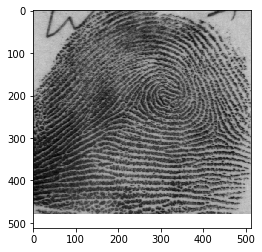

In [109]:
pth, img, cls = load_data(1)[0]
plt.imshow(img, cmap='gray')

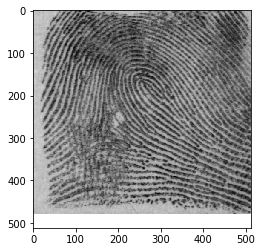

In [110]:
pth, img, cls = load_data(1)[0]
plt.imshow(img, cmap='gray')

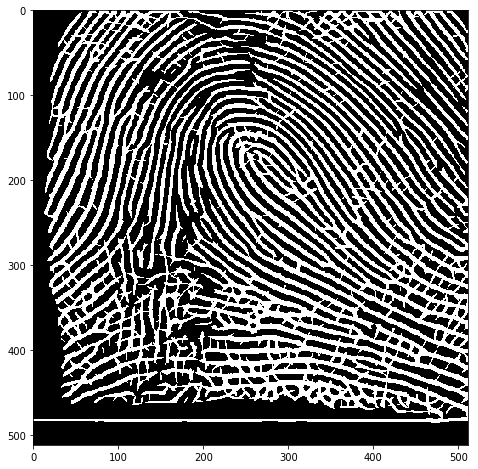

In [111]:
filters = build_filters()
res = process(normalize(img), filters)
mean=np.mean(res)*1.2
for i in range(res.shape[0]):
    for j in range(res.shape[1]):
        if(res[i][j]<mean):
            res[i][j]=0
        else:
            res[i][j]=255
plt.figure(figsize=(15, 8))
plt.imshow(res, cmap='gray')
scipy.misc.imsave('outfile.jpg', res)

# Skeletionization

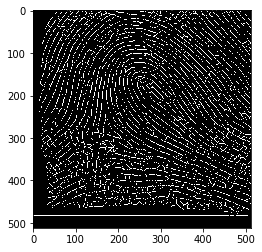

In [112]:
img = res.copy() 
skel = res.copy()
skel[:,:] = 0
kernel = cv.getStructuringElement(cv.MORPH_CROSS, (3,3))
while True:
    eroded = cv.morphologyEx(img, cv.MORPH_ERODE, kernel)
    temp = cv.morphologyEx(eroded, cv.MORPH_DILATE, kernel)
    temp  = cv.subtract(img, temp)
    skel = cv.bitwise_or(skel, temp)
    img[:,:] = eroded[:,:]
    if cv.countNonZero(img) == 0:
        break
plt.imshow(skel, cmap='gray')

# FFT Part

[ 0.  0.  0. ...,  0.  0.  0.]


d:\anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


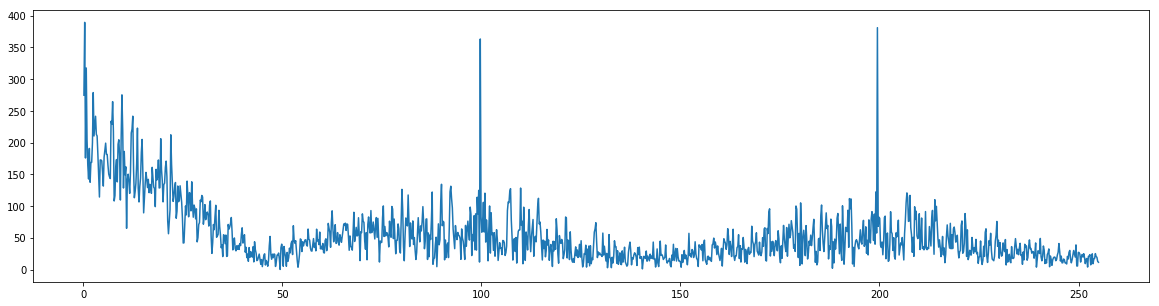

In [126]:
preFFT=skel.reshape(-1)
print(preFFT)
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack

# Number of samplepoints
N = preFFT.size//100
# sample spacing
T = 1.0 / (255*2)
x = np.linspace(0.0, N*T, N)
y = preFFT
yf = scipy.fftpack.fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N/2)
fig, ax = plt.subplots()
ax.plot(xf[1:], 2.0/N * np.abs(yf[1:N//2]))
#ax.set_yscale("log", nonposx='clip')
plt.gcf().set_size_inches(20, 5)
plt.show()


# attempt 2
try to implement equations found on the fucking paper : http://www.math.tau.ac.il/~turkel/imagepapers/fingerprint.pdf

In [114]:
I = img.copy()

M0, VAR0 = 100, 100

M = I.sum()/I.shape[0]/I.shape[1]
VAR = ((I-M)**2).sum()/I.shape[0]/I.shape[1]

G = -np.sqrt(VAR0*(I-M)**2/VAR)
G[I > M] *= -1
G += M0

Dx = cv.Sobel(G,cv.CV_64F,1,0,ksize=15)
Dy = cv.Sobel(G,cv.CV_64F,0,1,ksize=15)

THETA = np.zeros_like(G)

for i in range(0, G.shape[0]-8):
    for j in range(0, G.shape[1]-8):
        dx = Dx[i:i+16, j:j+16]
        dy = Dy[i:i+16, j:j+16]
        
        vx = (2*dx*dy).sum()
        vy = (dx**2-dy**2).sum()
        
        THETA[i+8, j+8] = 0.5*np.arctan(vy/vx)
    

PHIx = cv.blur(np.cos(2*THETA),(5,5))
PHIy = cv.blur(np.sin(2*THETA),(5,5))
O = 0.5*np.arctan(PHIy/PHIx) # from p.12 eq.12 with assumption that O = 0.5 arctan() instead of tan()

d:\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


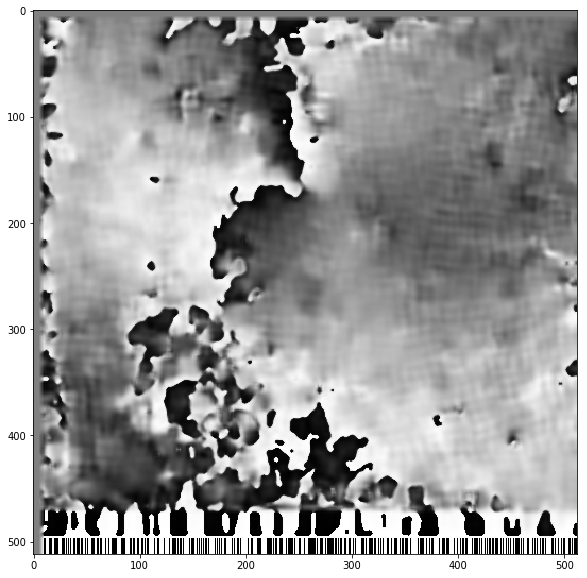

In [1217]:
plt.figure(figsize=(10, 10))
plt.imshow(normalize(O)*255, cmap='gray') # WTF